# 보팅 방식의 앙상블 - "Voting Classifier"

<b> - 위스콘신 유방암 데이터 셋 이용<br></b>
<b> => '로지스틱 회귀' & 'KNN'을 이용합니다. </b>

In [2]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

#개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
#voting 속성의 경우, hard : 하드 보팅방식, soft : 소프트 보팅방식을 의미한다.
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

#VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy))

#개별모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]

for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy))

Voting 분류기 정확도 : 0.9474
LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

보팅 분류기의 정확도가 개별 분류기의 정확도보다 조금 더 높게 나타났는데, 데이터의 다양한 요건에 따라 개별 분류기의 성능이 보팅 분류기보다 높게 나타나는 경우도 있다. 하지만 대부분의 경우, 보팅 분류기의 정확도가 개별 분류기보다 뛰어나다. 그 이유는 어떤 문제에 접근했을때, 그 문제를 다양한 관점에서 보는 것이 문제해결의 열쇠가 되는 경우와 마찬가지다. 다양한 관점을 가진 분류기들을 수십~수천개 사용하여 결합한후 다양한 상황을 학습하게 하여 더 뛰어난 분류 모델을 만들 수 있다.

# 배깅 방식의 앙상블 - "랜덤 포레스트"

In [4]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df
def get_human_dataset():
    #데이터 로드
    feature_name_df = pd.read_csv('UCI HAR Datasets/UCI HAR Dataset/features.txt', sep=' ', header=None, names=['column_index', 'column_name'])
    
    #중복데이터 피쳐이름 재명명
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    #피쳐 이름을 칼럼으로 부여하기 위해 리스트 객체로 만듦
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    #train feature 데이터와 test feature 데이터를  DataFrame으로 로딩. 칼럼명은 feature_name으로
    X_train = pd.read_csv('UCI HAR Datasets/UCI HAR Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('UCI HAR Datasets/UCI HAR Dataset/test/X_test.txt', sep='\s+', names=feature_name)
    
    #train 레이블와 test 레이블을  DataFrame으로 로딩. 칼럼명은 'action'으로
    y_train = pd.read_csv('UCI HAR Datasets/UCI HAR Dataset/train/y_train.txt', sep='\s+', names=['action'])
    y_test= pd.read_csv('UCI HAR Datasets/UCI HAR Dataset/test/y_test.txt', sep='\s+', names=['action'])
    
    #로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 사용자행동인식데이터 셋을 이용
X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9253


## - "랜덤 포레스트" 의 하이퍼 파라미터 및 튜닝
<ul>
    <li><p><b>n_estimator</b> : 결정트리의 개수.(디폴트 : 10)</p></li>
    <li><p><b>max_features</b> : 트리를 분할할때 참조하는 피쳐의 개수(디폴트는 'auto' => sqrt(전체피쳐 개수) 와 같음)</p></li>
    <li><p><b>max_depth, min_samples_leaf 등</b> : 결정트리에서 과적합 개선을 위해 튜닝했던 하이퍼 파라미터가 똑같이 적용됨</p></li>
</ul>

In [6]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

최적 하이퍼 파라미터 : 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

### * n_estimator 만 300으로 하여 결정트리의 개수를 300개로 늘려서 다시 학습해보자.

In [7]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0)

rf_clf1.fit(X_train, y_train)
pred=rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9165


## - 랜덤포레스트에서의 "피쳐 중요도" 살펴보기

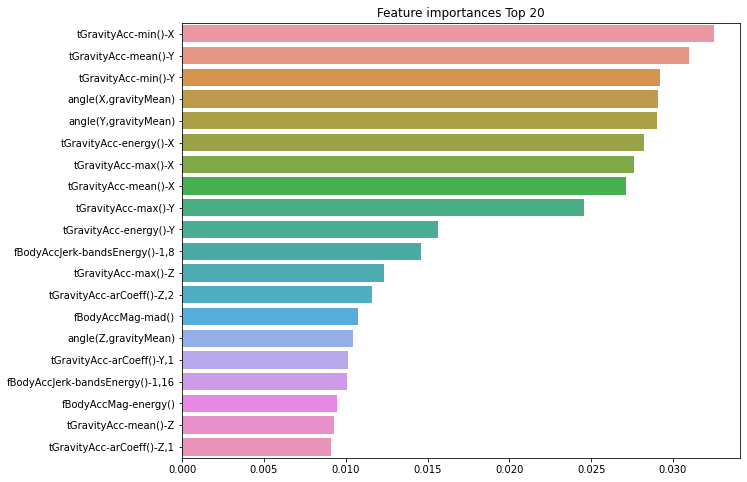

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# 부스팅 방식의 앙상블 - "GBM"

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간 : {0:.1f} 초'.format(time.time()-start_time))

GBM 정확도 : 0.9386
GBM 수행 시간 : 691.4 초


먼저 정확도를 보자. 기본 하이퍼 파라미터만으로도 93.86%의 예측 정확도를 보여준다. 앞서 나온 랜덤 포레스트보다 나은 예측 성능을 가지는 것을 확인할 수 있다. 일반적으로 GBM이 랜덤포레스트보다는 예측 성능이 뛰어나다.

그러나 문제는 수행시간이 오래걸린다는 것이다. 위의 수행시간은 691.4초로 대략 11분 정도가 걸렸다. 약한학습기의 순차적인 예측 오류보정을 해나가는 특성때문에 멀티 CPU 코어를 사용하더라도 병렬처리가 지원될 수 없기때문에 이렇게 오래걸리는 것이다.

## - "GBM" 의 하이퍼 파라미터 및 튜닝
<ul>
    <li><pre><b>n_estimator</b> : Weak Learner의 개수.(디폴트 : 100) 
-> 개수가 많아질수록 예측 성능이 일정 수준까지 좋아질 수 있다. 그러나 수행시간이 오래 걸린다. </pre></li>
    <li><pre><b>loss</b> : 경사하강법에서 사용한 Cost Function을 지정한다. (디폴트는 'deviance')</pre></li>
    <li><pre><b>learning_rate</b> : 학습을 진행할때, 얼만큼의 스텝으로 최소점에 도달할지를 정한다.
-> 주로 n_estimator와 상호보완적으로 조합해 사용한다.</pre></li>
    <li><pre><b>subsample</b> : weak learner가 학습에 사용하는 데이터의 샘플링 비율을 말한다. 과적합이 염려되는 경우 줄이는 용도로 사용된다.</pre></li>
</ul>

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


너무 오래걸린다... 그래서 책에 나온 결과로 대체한다.
<p></p>
[책에 나온 결과] <br>
최적 하이퍼 파라미터 :<br>
{'learning_rate': 0.05, 'n_estimators': 500}<br>
최고 예측 정확도 : 0.9010<br>

In [ ]:
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))

최적으로 학습된 estimator로 예측을 수행해보았다. 너무 오래걸린다.... 그래서 책에 나온 결과로 대체한다.
<p></p>
[책에 나온 결과] <br>
GBM 정확도 : 0.9410<br>

GBM은 과적합에도 강한 뛰어난 예측 성능을 가졌으나, 수행시간이 너무 오래 걸린다는 단점이 존재한다. 그래디언트 부스팅 기법은 GBM을 기반으로 많은 알고리즘이 탄생했고, 이들 중 XGBOOST, LightGBM은 각광을 받고 있는 두개의 알고리즘이다.